In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '../../ETOPO1_Ice_g_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
k = 10
x0 = x[::k]
y0 = y[::k]
z0 = z[::k,::k]

In [4]:
75.023, -23.564, 134.96, 23.725

(75.023, -23.564, 134.96, 23.725)

In [5]:
i0 = np.argmin(np.abs(x0+180))
i1 = np.argmin(np.abs(x0-180))
j0 = np.argmin(np.abs(y0+80))
j1 = np.argmin(np.abs(y0-80))

In [6]:
x1 = x0[i0:i1]
y1 = y0[j0:j1]
z1 = z0[j0:j1,i0:i1]

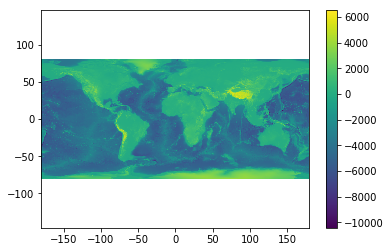

In [7]:
plt.pcolormesh(x1,y1,z1)
plt.axis('equal')
plt.colorbar()

In [8]:
np.savetxt('bathymetry', -z1)

In [9]:
x1.min(),x1.max()

(-180.0, 179.83333333333331)

In [10]:
y1.min(),y1.max()

(-79.99999999999997, 79.83333333333336)

In [11]:
x1.shape,y1.shape,z1.shape

((2160,), (960,), (960, 2160))

In [12]:
from scipy.misc import toimage

In [13]:
im = toimage(-z1)

c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


In [14]:
im.save('bathymetry.png')

In [15]:
z1.min(),z1.max()

(-10421, 6527)

# Slabs

In [16]:
from os import listdir
from os.path import isfile, join

In [37]:
root = '../../allslabs/'
files = [join(root,f) for f in listdir(root) if isfile(join(root,f)) and f[-9:] == '_clip.grd']
files

['../../allslabs/alu_slab1.0_clip.grd',
 '../../allslabs/cas_slab1.0_clip.grd',
 '../../allslabs/izu_slab1.0_clip.grd',
 '../../allslabs/ker_slab1.0_clip.grd',
 '../../allslabs/kur_slab1.0_clip.grd',
 '../../allslabs/mex_slab1.0_clip.grd',
 '../../allslabs/phi_slab1.0_clip.grd',
 '../../allslabs/ryu_slab1.0_clip.grd',
 '../../allslabs/sam_slab1.0_clip.grd',
 '../../allslabs/sco_slab1.0_clip.grd',
 '../../allslabs/sol_slab1.0_clip.grd',
 '../../allslabs/sum_slab1.0_clip.grd',
 '../../allslabs/van_slab1.0_clip.grd']

In [45]:
'van' in currentFile

True

In [43]:
'cas' in currentFile

False

In [48]:
d = {}
x = {}
y = {}
z = {}
for currentFile in files:
    d[currentFile] = Dataset(currentFile)


    x[currentFile] = d[currentFile].variables['x'][:]
    if('cas' in currentFile): x[currentFile] += 360
    y[currentFile] = d[currentFile].variables['y'][:]
    z[currentFile] = d[currentFile].variables['z'][:]
    print(z[currentFile].shape)


(751, 2451)
(651, 401)
(1451, 951)
(1251, 701)
(1226, 1751)
(701, 1251)
(401, 301)
(801, 851)
(2501, 1101)
(301, 451)
(501, 1001)
(1151, 1651)
(726, 451)


c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [49]:
x1.shape

(2160,)

In [50]:
xcontour = np.hstack([x1[int(x1.shape[0]/2):],x1[:int(x1.shape[0]/2)]+360])
ycontour = np.copy(y1)
zcontour = np.hstack([z1[:,int(x1.shape[0]/2):], z1[:,:int(x1.shape[0]/2)]])

../../allslabs/alu_slab1.0_clip.grd 	 167.0 216.0 - -278.79745 -6.264328
../../allslabs/cas_slab1.0_clip.grd 	 231.5 239.5 - -100.17566 -4.99232
../../allslabs/izu_slab1.0_clip.grd 	 129.0 148.0 - -686.76416 -1.0029683
../../allslabs/ker_slab1.0_clip.grd 	 174.0 188.0 - -700.34814 -2.8065534
../../allslabs/kur_slab1.0_clip.grd 	 129.0 164.0 - -724.17883 -5.8486433
../../allslabs/mex_slab1.0_clip.grd 	 254.0 279.0 - -294.82733 0.40164545
../../allslabs/phi_slab1.0_clip.grd 	 122.0 128.0 - -224.67575 -6.422098
../../allslabs/ryu_slab1.0_clip.grd 	 122.0 139.0 - -287.92587 0.7804123
../../allslabs/sam_slab1.0_clip.grd 	 278.0 300.0 - -742.31775 1.8256445
../../allslabs/sco_slab1.0_clip.grd 	 328.0 337.0 - -260.68948 -4.877502
../../allslabs/sol_slab1.0_clip.grd 	 145.0 165.0 - -616.64825 -1.8132368
../../allslabs/sum_slab1.0_clip.grd 	 91.0 124.0 - -635.29974 -2.9774964
../../allslabs/van_slab1.0_clip.grd 	 164.0 173.0 - -331.33304 -3.8924878


(-2.4980018054066022e-15,
 358.3333333333333,
 -79.99999999999997,
 78.33333333333336)

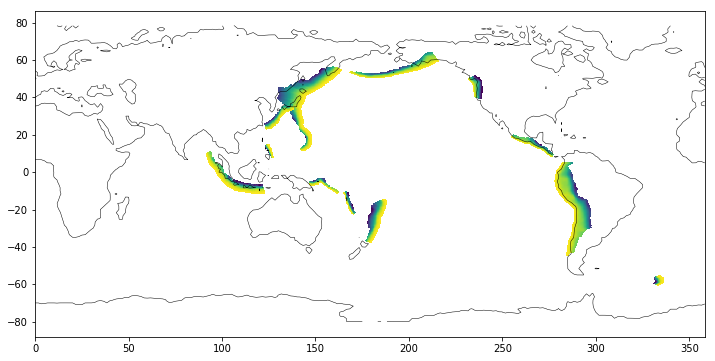

In [51]:
plt.figure(figsize=(12,6))
k = 10
plt.contour(xcontour[::k], ycontour[::k], zcontour[::k,::k],[0.0],linewidths=0.5,colors='k')
for currentFile in files:
    print(currentFile, '\t',x[currentFile].min(),  x[currentFile].max(), '-', z[currentFile].min(), z[currentFile].max())
    plt.pcolormesh(x[currentFile][::k], y[currentFile][::k], z[currentFile][::k,::k])
    
plt.axis('equal')